In [155]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import sys 
import os

# this line walks up file directory so rule-vetting is cwd
# Currently this breaks if chunk is run multiple times
os.chdir(os.path.dirname(os.path.dirname(os.path.dirname(os.path.dirname(os.getcwd())))))
print(os.getcwd())

import rulevetting.api.viz as viz
from rulevetting.projects.csi_pecarn.dataset import Dataset
from rulevetting.projects.csi_pecarn.tree_functions import *

from sklearn import tree
from sklearn.inspection import permutation_importance
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import RocCurveDisplay

df_all = Dataset().get_data()
df_ran = Dataset().get_data(control_types=['ran'])
df_moi = Dataset().get_data(control_types=['moi'])
df_ems = Dataset().get_data(control_types=['ems'])

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
/


In [156]:
df = df_ran[0]
df.columns
#df[df['non_verbal'] == 1]
posthoc_columns = [col for col in df.columns if 'posthoc' in col]
outside_columns = [col for col in df.columns if 'outside' in col]
improved_columns = [col for col in df.columns if 'improved' in col]
df = df.drop(posthoc_columns,axis=1).copy()
df = df.drop(outside_columns,axis=1).copy() 
df = df.drop(improved_columns,axis=1).copy() 
df.columns

Index(['AlteredMentalStatus', 'LOC', 'FocalNeuroFindings', 'PainNeck',
       'PosMidNeckTenderness', 'TenderNeck', 'Torticollis', 'SubInj_Head',
       'SubInj_Face', 'SubInj_Ext', 'SubInj_TorsoTrunk', 'Predisposed',
       'HighriskDiving', 'HighriskFall', 'HighriskHanging', 'HighriskHitByCar',
       'HighriskMVC', 'HighriskOtherMV', 'AxialLoadAnyDoc', 'axialloadtop',
       'Clotheslining', 'CervicalSpineImmobilization', 'GCSEye', 'MotorGCS',
       'VerbalGCS', 'TotalGCS', 'PtCompPainFace', 'PtCompPainHead',
       'PtCompPainChest', 'PtTenderNeck', 'PtTenderFace', 'PtTenderHead',
       'PassRestraint', 'Assault', 'ChildAbuse', 'csi_injury', 'EMSArrival',
       'NonAmbulatory', 'AVPUDetails_AVPU_A', 'AVPUDetails_AVPU_P',
       'AVPUDetails_AVPU_U', 'AVPUDetails_AVPU_V', 'AVPUDetails_AVPU_nan',
       'ReceivedInTransfer', 'PtAmbulatoryPriorArrival', 'ArrPtIntub',
       'PtCompPainNeckMove', 'helmet', 'HEENT', 'Cardiovascular',
       'Respiratory', 'Gastrointestinal', 'Musculo

In [157]:
av_list = ['AlteredMentalStatus', 'LOC', 'FocalNeuroFindings', 'PainNeck',
       'PosMidNeckTenderness', 'TenderNeck', 'Torticollis', 'SubInj_Head',
       'SubInj_Face', 'SubInj_Ext', 'SubInj_TorsoTrunk', 'Predisposed',
       'HighriskDiving', 'HighriskFall', 'HighriskHanging', 'HighriskHitByCar',
       'HighriskMVC', 'HighriskOtherMV', 'AxialLoadAnyDoc', 'axialloadtop',
       'Clotheslining', 'NonAmbulatory', 'csi_injury']

In [219]:
def data_preparation(df, av, age, outside):
    posthoc_columns = [col for col in df.columns if 'posthoc' in col]
    outside_columns = [col for col in df.columns if 'outside' in col]
    improved_columns = [col for col in df.columns if 'improved' in col]
    av_list = ['AlteredMentalStatus', 'LOC', 'FocalNeuroFindings', 'PainNeck',
       'PosMidNeckTenderness', 'TenderNeck', 'Torticollis', 'SubInj_Head',
       'SubInj_Face', 'SubInj_Ext', 'SubInj_TorsoTrunk', 'Predisposed',
       'HighriskDiving', 'HighriskFall', 'HighriskHanging', 'HighriskHitByCar',
       'HighriskMVC', 'HighriskOtherMV', 'AxialLoadAnyDoc', 'axialloadtop',
       'Clotheslining', 'NonAmbulatory', 'csi_injury']
    
    if age == '<2':
        df = df[df['VeryYoung'] == 1]
    elif age == '2-5':
        df = df[(df['NonVerbal'] == 1) & (df['VeryYoung'] == 0)]
    elif age == '5-12':
        df = df[(df['YoungAdult'] == 0) & (df['NonVerbal'] == 0)]
    elif age == '>12':
        df = df[df['YoungAdult'] == 1]
        
    df = df.drop(['VeryYoung', 'NonVerbal','YoungAdult',
                  'ReceivedInTransfer','CervicalSpineImmobilization'],axis=1).copy()
    
    if av:
        df = df[av_list]
    elif outside:
        df = df.drop(posthoc_columns,axis=1).copy()
        df = df.drop(improved_columns,axis=1).copy() 
    else:
        df = df.drop(posthoc_columns,axis=1).copy()
        df = df.drop(outside_columns,axis=1).copy()  
        df = df.drop(improved_columns,axis=1).copy() 
    
    if age == '<2':
        df = df.drop(['NonAmbulatory'],axis=1).copy()
            
    return df

#### Leonard et al(2011)

The sensitivity and specificity of the rule proposed by Leonard et al(2011) in three control groups

In [220]:
Leonard = ['AlteredMentalStatus','FocalNeuroFindings','PainNeck','Torticollis',
          'SubInj_TorsoTrunk','Predisposed','HighriskDiving','HighriskMVC']

## Decision trees

All models are trained on training set, and evaluate on tuning set.

The plots shows ROC curves for four different classifiers:

- CART
- CART with max_depth = 5
- Random Forest
- Random Forest with weighted class (10:1)

And the dashed lines mark the FPR and TPR of baselines.

Notice: TPR = sensitivity, FPR = 1-specificity

### control group: random

(113, 57) (38, 57)
[1.0, 0.44]


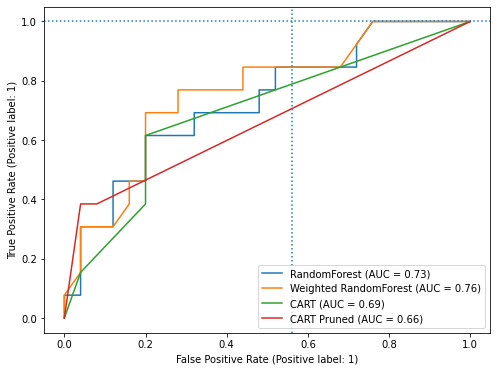

In [221]:
# control group: random

# data preparation --------------
data_list = df_ran
data_train = data_preparation(df_ran[0],av = False, age = '2-5', outside = False)
data_tuning = data_preparation(df_ran[1],av = False, age = '2-5', outside = False)
print(data_train.shape, data_tuning.shape)

Leo_evaluation = evaluate_vlist(data_tuning, Leonard)
print(Leo_evaluation)

# X = data_train.loc[:,'AlteredMentalStatus':'Clotheslining']
X = data_train.drop(['csi_injury'],axis=1).copy()
y = data_train['csi_injury'].astype('int')
# X_tuning = data_tuning.loc[:,'AlteredMentalStatus':'Clotheslining']
X_tuning = data_tuning.drop(['csi_injury'],axis=1).copy()
y_tuning = data_tuning['csi_injury'].astype('int')

# fiting models ---------------
cart = tree.DecisionTreeClassifier(random_state = 1)
cart = cart.fit(X,y)

cart_small = tree.DecisionTreeClassifier(max_depth = 3,random_state = 1)
cart_small = cart_small.fit(X,y)

rf = RandomForestClassifier(n_estimators = 200,random_state = 1)
rf = rf.fit(X,y)

rf_weighted = RandomForestClassifier(class_weight = {1:10, 0:1},random_state = 1)
rf_weighted = rf_weighted.fit(X,y)

# visulization --------------------
fig, ax = plt.subplots(figsize=(8,6))
RocCurveDisplay.from_estimator(rf, X_tuning, y_tuning, ax=ax, name = "RandomForest")
RocCurveDisplay.from_estimator(rf_weighted, X_tuning, y_tuning, ax=ax, name = "Weighted RandomForest")
RocCurveDisplay.from_estimator(cart_small, X_tuning, y_tuning, ax=ax, name = "CART")
RocCurveDisplay.from_estimator(cart, X_tuning, y_tuning, ax=ax, name = "CART Pruned")

ax.axhline(Leo_evaluation[0],linestyle = ":")
ax.axvline(1-Leo_evaluation[1],linestyle = ":")

plt.show()

- ReceivedInTransfer ？
- PassRestraint
- CervicalSpineImmobilization ?
- PtCompPainNeck
- PtCom

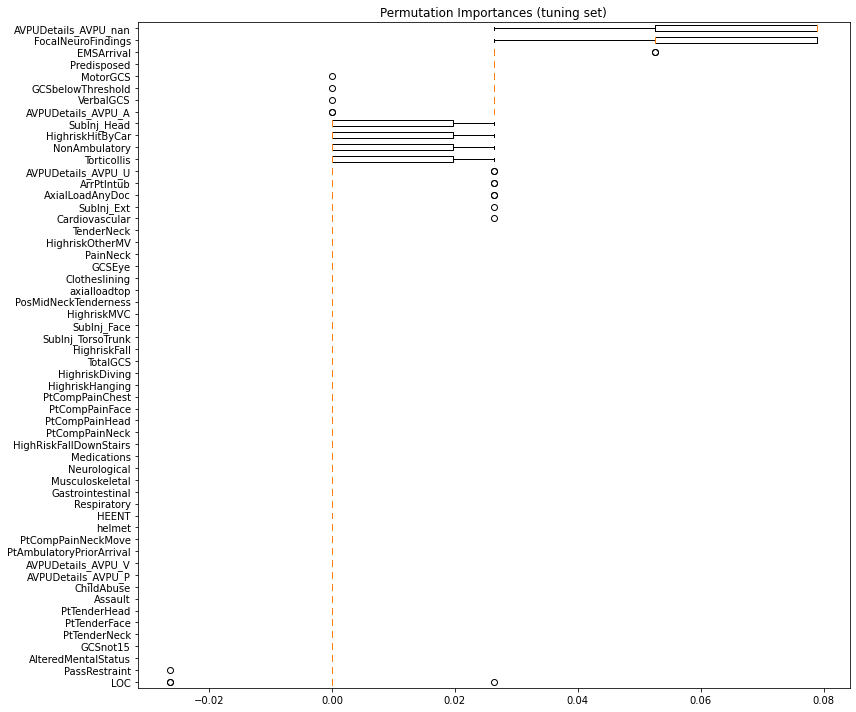

In [222]:
# plots for permutation importantce of RF algorithm on tuning set
result = permutation_importance(rf, X_tuning, y_tuning, n_repeats = 10, random_state = 1)
sorted_idx = result.importances_mean.argsort()

fig, ax = plt.subplots(figsize=(12,10))
ax.boxplot(result.importances[sorted_idx].T, vert=False, labels=X.columns[sorted_idx])
ax.set_title("Permutation Importances (tuning set)")
fig.tight_layout()
plt.show()

[1.0, 0.3902439024390244]


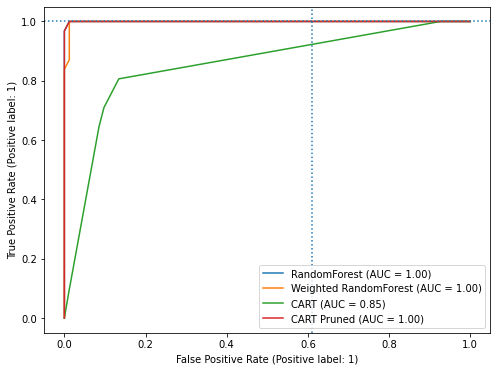

In [225]:
Leo_evaluation = evaluate_vlist(data_train, Leonard)
print(Leo_evaluation)

# visulization --------------------
fig, ax = plt.subplots(figsize=(8,6))
RocCurveDisplay.from_estimator(rf, X, y, ax=ax, name = "RandomForest")
RocCurveDisplay.from_estimator(rf_weighted, X, y, ax=ax, name = "Weighted RandomForest")
RocCurveDisplay.from_estimator(cart_small, X, y, ax=ax, name = "CART")
RocCurveDisplay.from_estimator(cart, X, y, ax=ax, name = "CART Pruned")

ax.axhline(Leo_evaluation[0],linestyle = ":")
ax.axvline(1-Leo_evaluation[1],linestyle = ":")

plt.show()

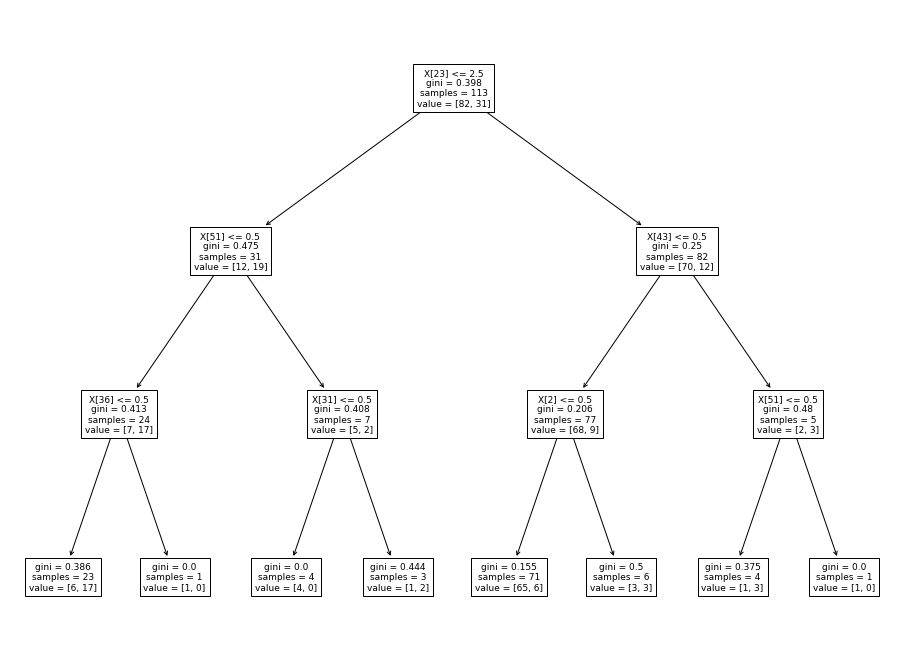

In [226]:
plt.figure(figsize=(16,12))  # set plot size (denoted in inches)
tree.plot_tree(cart_small, fontsize=9)
plt.show()    

In [214]:
X.columns[[23,13,18,44,6]]

Index(['VerbalGCS', 'HighriskFall', 'AxialLoadAnyDoc', 'HEENT', 'Torticollis'], dtype='object')

In [139]:
evaluate_vlist(data_tuning, Leonard)

[0.8928571428571429, 0.3333333333333333]

In [188]:
print(data_tuning.shape)
print(evaluate_vlist(data_tuning, Leonard))
print(data_train.shape)
print(evaluate_vlist(data_train, Leonard))

(84, 57)
[0.9166666666666666, 0.4666666666666667]
(261, 57)
[0.9166666666666666, 0.3672316384180791]


In [189]:
data_tuning[data_tuning['csi_injury'] == 1]

,,,,AlteredMentalStatus,LOC,FocalNeuroFindings,PainNeck,PosMidNeckTenderness,TenderNeck,Torticollis,SubInj_Head,SubInj_Face,SubInj_Ext,...,Cardiovascular,Respiratory,Gastrointestinal,Musculoskeletal,Neurological,Medications,HighRiskFallDownStairs,PtCompPainNeck,GCSnot15,GCSbelowThreshold
id,case_id,site,control_type,,,,,,,,,,,,,,,,,,,,,
110016,110016,1,case,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
310273,310273,3,case,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
310303,310303,3,case,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
310306,310306,3,case,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
310301,310301,3,case,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
410490,410490,4,case,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
610715,610715,6,case,1.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
610710,610710,6,case,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
710876,710876,7,case,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [190]:
data_train.columns

Index(['AlteredMentalStatus', 'LOC', 'FocalNeuroFindings', 'PainNeck',
       'PosMidNeckTenderness', 'TenderNeck', 'Torticollis', 'SubInj_Head',
       'SubInj_Face', 'SubInj_Ext', 'SubInj_TorsoTrunk', 'Predisposed',
       'HighriskDiving', 'HighriskFall', 'HighriskHanging', 'HighriskHitByCar',
       'HighriskMVC', 'HighriskOtherMV', 'AxialLoadAnyDoc', 'axialloadtop',
       'Clotheslining', 'GCSEye', 'MotorGCS', 'VerbalGCS', 'TotalGCS',
       'PtCompPainFace', 'PtCompPainHead', 'PtCompPainChest', 'PtTenderNeck',
       'PtTenderFace', 'PtTenderHead', 'PassRestraint', 'Assault',
       'ChildAbuse', 'csi_injury', 'EMSArrival', 'NonAmbulatory',
       'AVPUDetails_AVPU_A', 'AVPUDetails_AVPU_P', 'AVPUDetails_AVPU_U',
       'AVPUDetails_AVPU_V', 'AVPUDetails_AVPU_nan',
       'PtAmbulatoryPriorArrival', 'ArrPtIntub', 'PtCompPainNeckMove',
       'helmet', 'HEENT', 'Cardiovascular', 'Respiratory', 'Gastrointestinal',
       'Musculoskeletal', 'Neurological', 'Medications',
       'Hig

## Simple Tree

### Using one variable at one time (same as Leonard)

In [229]:
data_train = data_train.drop(['GCSEye','MotorGCS','VerbalGCS','TotalGCS'],axis=1).copy()
results = simple_tree([data_train,data_tuning], tree_method = 'one', select_method = "semi_gini")
v = results[0]
e_tuning = results[2]

In [230]:
pd.DataFrame(data = {'variable': v, 'TPR' :e_tuning['TPR'], 'FPR' :e_tuning['FPR'] })

,variable,TPR,FPR
0,Predisposed,0.000000,0.00
1,HighriskDiving,0.076923,0.00
2,Clotheslining,0.076923,0.00
3,Cardiovascular,0.076923,0.00
4,ArrPtIntub,0.076923,0.04
5,PtCompPainNeckMove,0.307692,0.08
6,AVPUDetails_AVPU_nan,0.461538,0.12
7,HighriskHanging,0.461538,0.20
8,helmet,0.461538,0.24
9,AVPUDetails_AVPU_V,0.461538,0.24


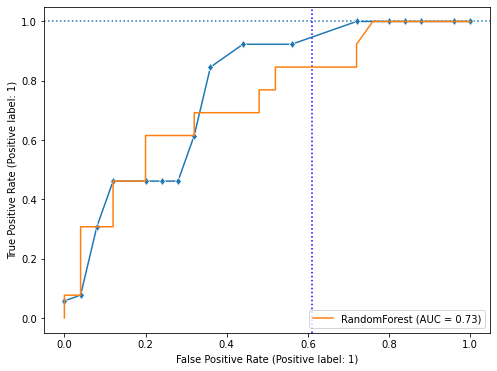

In [231]:
fig, ax = plt.subplots(figsize=(8,6))
ax.axhline(Leo_evaluation[0],linestyle = ":")
ax.axvline(1-Leo_evaluation[1],linestyle = ":",color = 'blue')
sns.lineplot(x='FPR', y= 'TPR', data = e_tuning, marker='d')
RocCurveDisplay.from_estimator(rf, X_tuning, y_tuning, ax=ax, name = "RandomForest")
plt.show()

### Using one or two variable(s) at one time

- threshold of whether use the second variable is sensitivity > 90%

In [178]:
results_ran = simple_tree([data_train,data_tuning], tree_method = 'two', select_method = "semi_gini")
v_ran = results_ran[0]
e_ran_tuning = results_ran[2]

In [179]:
summary_df = pd.DataFrame(data = {})

v_0 = []
v_1 = []
for v in v_ran:
    v_0.append(v[0])
    v_1.append(v[1])
summary_df['ran_0'] = v_0
summary_df['ran_1'] = v_1

summary_df

,ran_0,ran_1
0,HighriskDiving,no need
1,FocalNeuroFindings,no need
2,Clotheslining,EMSArrival
3,GCSbelowThreshold,no need
4,axialloadtop,no need
5,Torticollis,no need
6,ChildAbuse,no observations
7,HighriskMVC,no need
8,AVPUDetails_AVPU_nan,no need
9,ArrPtIntub,PosMidNeckTenderness


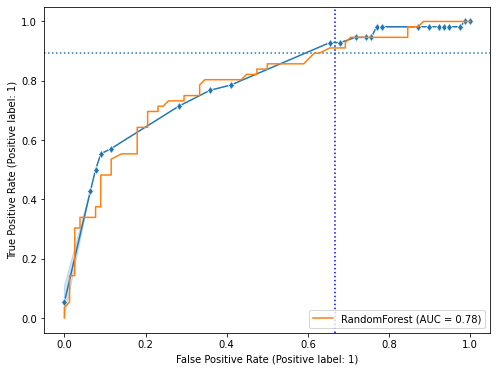

In [184]:
fig, ax = plt.subplots(figsize=(8,6))
ax.axhline(Leo_evaluation[0],linestyle = ":")
ax.axvline(1-Leo_evaluation[1],linestyle = ":",color = 'blue')
# sns.lineplot(x='FPR', y= 'TPR', data = e_ran_tuning, marker='d')
sns.lineplot(x='FPR', y= 'TPR', data = e_tuning, marker='d')
RocCurveDisplay.from_estimator(rf, X_tuning, y_tuning, ax=ax, name = "RandomForest")
plt.show()

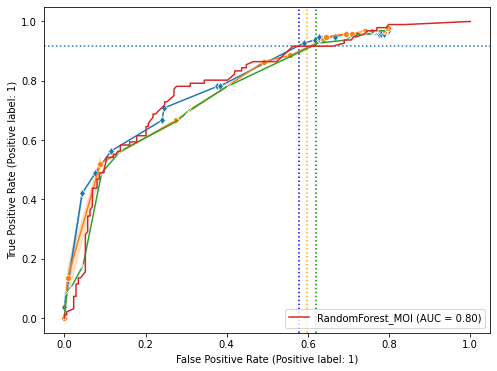

In [18]:
fig, ax = plt.subplots(figsize=(8,6))
ax.axhline(Leo_evaluation_ran[0],linestyle = ":")
ax.axvline(1-Leo_evaluation_ran[1],linestyle = ":",color = 'blue')
sns.lineplot(x='FPR', y= 'TPR', data = e_ran_semi, marker='d')
ax.axvline(1-Leo_evaluation_ems[1],linestyle = ":",color = 'orange')
sns.lineplot(x='FPR', y= 'TPR', data = e_ems_semi, marker='o')
ax.axvline(1-Leo_evaluation_moi[1],linestyle = ":",color = 'green')
sns.lineplot(x='FPR', y= 'TPR', data = e_moi_semi,  marker='x')
RocCurveDisplay.from_estimator(rf, X_tuning, y_tuning, ax=ax, name = "RandomForest_MOI")
# RocCurveDisplay.from_estimator(rf, X_tuning, y_tuning, ax=ax, name = "RandomForest")
plt.show()